## Run XID+ on the LOFAR image using teh pybdsf gaussian components as the prior list

Also give each source a PSF with sig max and min equal to the maj and min axis from PYBDSF

In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import pymoc
import glob
from time import sleep
import os
from astropy.nddata.utils import Cutout2D
from astropy.convolution import Gaussian2DKernel
#import herschelhelp.cutouts_server as ctts
import scipy

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp import image_plotting,utils
import pyvo as vo
import glob

import copy

In [2]:
def get_cutout_data_and_wcs(image,ra,dec,wcs,box_length):
    
    c = SkyCoord(ra*u.degree,dec*u.degree,unit='deg')
    length_x, length_y = image_plotting.get_pix_length(image,wcs,box_length,ra,dec)
    pix_cent_x, pix_cent_y = wcs.wcs_world2pix(ra,dec,0,ra_dec_order=True)
    pixscale = np.array(wcs.wcs_pix2world(0,0,0)) - np.array(wcs.wcs_pix2world(1,1,0))
    if type(box_length)==list:
        imgcut = Cutout2D(image, c, size=[box_length[0]*u.degree,box_length[1]*u.degree], wcs=wcs)
    else:
        imgcut = Cutout2D(image, c, size=[box_length*u.degree,box_length*u.degree], wcs=wcs)
    wcscut = imgcut.wcs
    imgcut = imgcut.data
    
    return(imgcut,wcscut)

In [4]:
lofar_orig = Table.read('../data/data_release/final_component_catalogue-v1.0.fits')
print(len(lofar_orig))
lofar_orig[0]

86000


Component_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Created,Deblended_from,Parent_Source
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes29,bytes22,bytes22
ILTJ153936.98+580651.7,234.90409574742577,58.11436685178417,0.000910655435717371,0.0010915293854267178,0.03887940165446956,0.014258139852887139,0.002666120985100087,0.0009167623793084566,S,0.008174848212191131,0.004976624331647756,138.96192976652347,0.002918164787813265,0.0016483856941018943,35.943946342848044,0.008003137446445173,0.004686688655986016,138.96192976652344,Ingest components,,ILTJ153936.98+580651.7


In [44]:
fname = '../data/image_full_ampphase_di_m.NS.psf.fits'
hdulist = fits.open(fname)
radim_header_psf = hdulist[0].header
radim_wcs_psf = wcs.WCS(radim_header_psf).celestial
radim_data_psf = hdulist[0].data[0][0]
radim_pixsize = abs(radim_wcs_psf.wcs.cdelt[0])*3600
hdulist.close()

fname = '../data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0].astype('f4')*1000 #convert to mJy
hdulist.close()
radim_header['NAXIS']=2
radim_header['WCSAXES']=2

fname = '../data/data_release/radio_rms_image.fits'
hdulist = fits.open(fname)
radim_header_err = hdulist[0].header
radim_wcs_err = wcs.WCS(radim_header_err).celestial
radim_err = hdulist[0].data[0][0].astype('f4')*1000 #convert to mJy
hdulist.close()

fname = '../data/data_release/image_full_ampphase_di_m.NS.mask01-2.fits'
hdulist = fits.open(fname)
radim_header_mask = hdulist[0].header
mask_deconv_wcs = wcs.WCS(radim_header_mask).celestial
mask_deconv = hdulist[0].data[0][0]
hdulist.close()


#remove the 3rd and 4th axis from teh lofar image as they confuse the plotting functions in xidplus
#these extra dimesnions are for frequency and aren't included in these fits files
for n in ['3','4']:
    for val in ['RPIX','DELT','UNIT','TYPE','RVAL']:
        try:
            radim_header.remove('C{}{}'.format(val,n))
        except:()
radim_header.remove('NAXIS3')
radim_header.remove('NAXIS4')
radim_header['NAXIS']=2
radim_header['WCSAXES']=2

  'HZ' -> 'Hz'. [astropy.wcs.wcs]
  'HZ' -> 'Hz'.


1


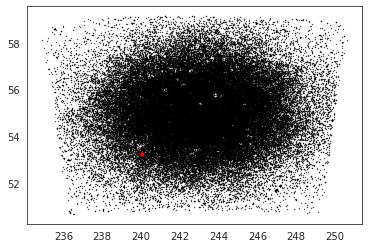

3 gaussian components in the moc
240.064779191718 53.24940682803362


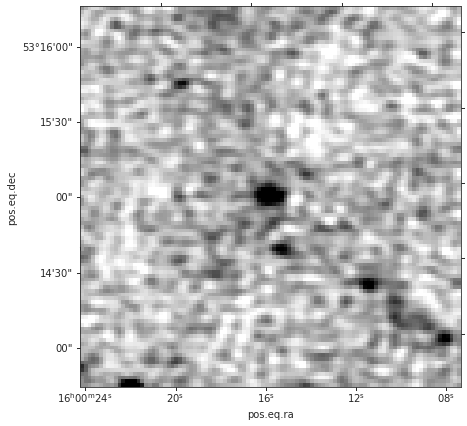

Component_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Created,Deblended_from,Parent_Source
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes29,bytes22,bytes22
ILTJ160011.28+531421.1,240.04701410008857,53.23920400924216,0.00013289366353655603,7.630629760464573e-05,0.00021833498739245208,6.0078047446789136e-05,0.00025160527362624413,3.7324686021485594e-05,S,0.0018216103590890625,0.0013243927906815172,73.2606847546958,0.00032055522461017604,0.0001656236175945399,19.306112238478068,0.0,0.0,0.0,Ingest components,,ILTJ160011.28+531421.1
ILTJ160015.04+531436.3,240.06265293201858,53.243424045684556,0.00020549670917710083,8.212149059525162e-05,0.0002202703285718775,6.964593850043873e-05,0.0002150254204376552,3.8071189854377616e-05,S,0.0021594703703842104,0.0013188176712303071,80.18285910525069,0.0004878596267076875,0.00018299970573679766,15.770148152722987,0.0,0.0,0.0,Ingest components,,ILTJ160015.04+531436.3
ILTJ160015.55+531457.8,240.064779191718,53.24940682803362,0.0001587096677893057,7.135233017876435e-05,0.0007041724358324659,0.00011248209260295762,0.00038156057243349804,4.155696441702772e-05,S,0.0029009876273209745,0.0017686169971036815,80.39107042912823,0.000376508400256408,0.00016164625557174483,9.630556534445912,0.002374102384572974,0.0005891733877287122,80.39107042912823,Ingest components,,ILTJ160015.55+531457.8


In [58]:
#Select LOFAR gaussian sources to run XID+ on

n = 10000
mask = lofar_orig['DC_Maj']>0.0
ras = lofar_orig['RA'][mask][n:n+1]
decs = lofar_orig['DEC'][mask][n:n+1]
print(len(ras))
ID = lofar_orig['Component_Name'][mask][n:n+1]

majs = lofar_orig['Maj'][mask][n:n+1]
mins = lofar_orig['Min'][mask][n:n+1]


orig_fluxes = lofar_orig['Peak_flux'][mask][n:n+1]
orig_ferr = lofar_orig['E_Peak_flux'][mask][n:n+1]

x = lofar_orig['RA']
y = lofar_orig['DEC']
plt.scatter(x,y,s=0.1,c='black')

x = ras
y = decs
plt.scatter(x,y,s=10,c='red')
plt.show()

from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc_near=pymoc.util.catalog.catalog_to_moc(c,60,15)

moc_mask = inMoc(lofar_orig['RA'],lofar_orig['DEC'],moc_near)
moc = pymoc.util.catalog.catalog_to_moc(c,60,15)

print('{} gaussian components in the moc'.format(moc_mask.sum()))

plot_params = {'marker':['o','+','o','v','X','d'],
              'col':['green','cyan','orange','red'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False,False]}
n=1
fig = plt.figure(figsize=[7,7])
ra = ras[0]
dec = decs[0]
print(ra,dec)
box_length = 1.5/3600*n_size

wcs_plot,ax = image_plotting.image_plot(radim_data,ra,dec,radim_wcs,box_length,fig)
#wcs_plot,ax = image_plotting.image_plot(mask_deconv,ra,dec,mask_deconv_wcs,box_length,fig)
#plt.contour(prf.array,color='red')
plt.show()

lofar_orig[moc_mask]

In [46]:
prior=xidplus.prior(radim_data,radim_err,radim_header,radim_header, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior.prior_cat(lofar_orig['RA'],lofar_orig['DEC'],'prior_cat',ID=lofar_orig['Component_Name'],moc=moc)#Set input catalogue
prior.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

0


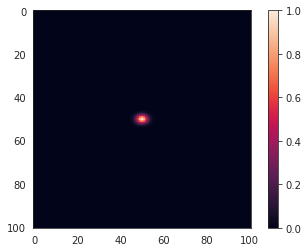

1


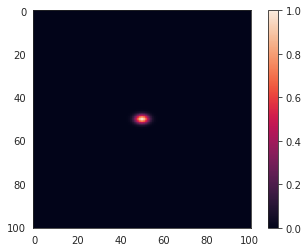

2


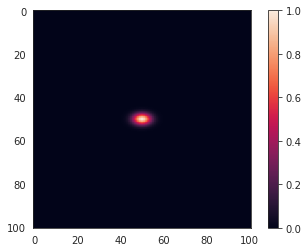

In [47]:
#generate PSFs for each source
#generate a psf for the first object in the catalogue 
n = 5
n_size = 101
FWHM_factor = 2*np.sqrt(2*np.log(2))
prfs = np.empty((np.sum(moc_mask),n_size,n_size))
pinds = np.empty((np.sum(moc_mask),n_size))
for i in range(np.sum(moc_mask)):
    print(i)
    #convert the maj and min axis to arcseconds and then calculate how many pixels that is
    #pixel size of the lofar image is 1.5"
    maj_use = lofar_orig['Maj'][moc_mask][i]*3600/1.5
    min_use = lofar_orig['Min'][moc_mask][i]*3600/1.5
    
    
    sig_maj = maj_use/FWHM_factor#/2.355
    sig_min = min_use/FWHM_factor


    prf = Gaussian2DKernel(sig_maj,sig_min,x_size=n_size,y_size=n_size)
    prf.normalize(mode='peak')
    
    prfs[i] = prf.array
    
    pinds[i] = np.array(np.arange(0,n_size))

    plt.imshow(prf.array)
    plt.colorbar()
    plt.show()



In [48]:
pind = np.array(np.arange(0,n_size))
prior.set_prfs(prfs,pinds,pinds)

prior.get_pointing_matrix_multiple_prf()
prior.upper_lim_map()

print('fitting '+ str(prior.nsrc)+' sources \n')
print('using ' +  str(prior.snpix) + ' pixels')

[-2.94956920e-02  9.70504308e-01  1.97050431e+00  2.97050431e+00
  3.97050431e+00  4.97050431e+00  5.97050431e+00  6.97050431e+00
  7.97050431e+00  8.97050431e+00  9.97050431e+00  1.09705043e+01
  1.19705043e+01  1.29705043e+01  1.39705043e+01  1.49705043e+01
  1.59705043e+01  1.69705043e+01  1.79705043e+01  1.89705043e+01
  1.99705043e+01  2.09705043e+01  2.19705043e+01  2.29705043e+01
  2.39705043e+01  2.49705043e+01  2.59705043e+01  2.69705043e+01
  2.79705043e+01  2.89705043e+01  2.99705043e+01  3.09705043e+01
  3.19705043e+01  3.29705043e+01  3.39705043e+01  3.49705043e+01
  3.59705043e+01  3.69705043e+01  3.79705043e+01  3.89705043e+01
  3.99705043e+01  4.09705043e+01  4.19705043e+01  4.29705043e+01
  4.39705043e+01  4.49705043e+01  4.59705043e+01  4.69705043e+01
  4.79705043e+01  4.89705043e+01  4.99705043e+01  5.09705043e+01
  5.19705043e+01  5.29705043e+01  5.39705043e+01  5.49705043e+01
  5.59705043e+01  5.69705043e+01  5.79705043e+01  5.89705043e+01
  5.99705043e+01  6.09705

In [49]:
from xidplus.numpyro_fit import LOFAR150
fit=LOFAR150.LOFAR_150(prior,num_samples=1000,num_warmup=1000)
samples = fit.get_samples()['src_f']
posterior = xidplus.posterior_numpyro(fit,[prior])

Number of divergences: 0


([<aplpy.core.FITSFigure at 0x2aad61438b90>],
 <Figure size 720x720 with 2 Axes>)

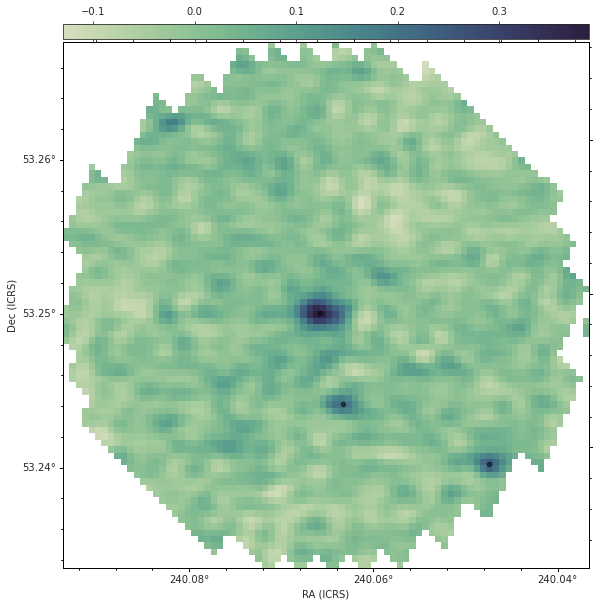

In [50]:
xidplus.plot_map([prior])

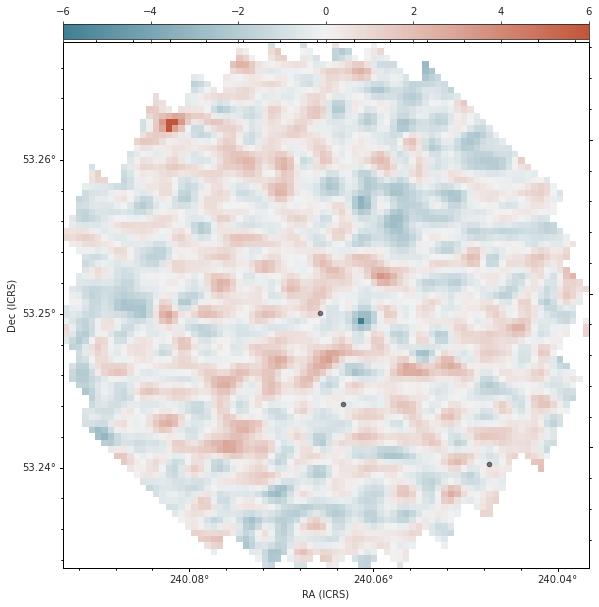

In [51]:
figs,fig=xidplus.plot_Bayes_pval_map([prior], posterior)

In [59]:
cat_tmp = xidplus.catalogue.create_LOFAR_cat(posterior,prior)
catalogue = Table.read(cat_tmp)
catalogue.rename_column('help_id','Component_Name')
catalogue_prfs = join(catalogue,lofar_orig,keys='Component_Name',)

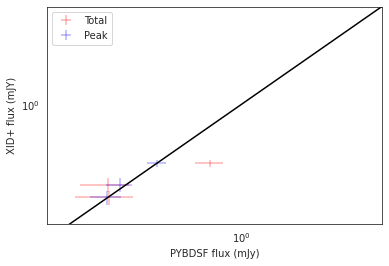

In [60]:
x = catalogue_prfs['Total_flux']*1000
xerr = catalogue_prfs['E_Total_flux']*1000
y = catalogue_prfs['F_LOFAR_150']
yerr = catalogue_prfs['FErr_LOFAR_150_u'] - catalogue_prfs['FErr_LOFAR_150_l']

plt.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='',c='red',label='Total',alpha=0.3)

x = catalogue_prfs['Peak_flux']*1000
xerr = catalogue_prfs['E_Peak_flux']*1000
y = catalogue_prfs['F_LOFAR_150']
yerr = catalogue_prfs['FErr_LOFAR_150_u'] - catalogue_prfs['FErr_LOFAR_150_l']

plt.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='',c='blue',label='Peak',alpha=0.3)

plt.plot([0,100],[0,100],c='black')
plt.yscale('log')
plt.xscale('log')


plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('PYBDSF flux (mJy)')
plt.ylabel('XID+ flux (mJY)')
plt.legend()
plt.show()

### Run with the restoring beam PSF

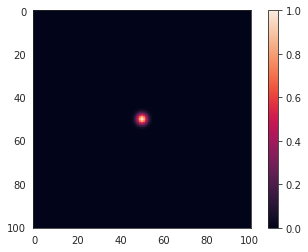

fitting 3 sources 

using 5033 pixels


In [64]:
n = 5
n_size = 101
FWHM_factor = 2*np.sqrt(2*np.log(2))



sig_maj = 4/FWHM_factor#/2.355
sig_min = min_use/FWHM_factor

prf = Gaussian2DKernel(sig_maj,x_size=n_size,y_size=n_size)
prf.normalize(mode='peak')

plt.imshow(prf.array)
plt.colorbar()
plt.show()

pind = np.array(np.arange(0,n_size))
prior.set_prf(prf.array,pind,pind)

prior.get_pointing_matrix()
prior.upper_lim_map()

print('fitting '+ str(prior.nsrc)+' sources \n')
print('using ' +  str(prior.snpix) + ' pixels')

In [65]:
from xidplus.numpyro_fit import LOFAR150
fit=LOFAR150.LOFAR_150(prior,num_samples=1000,num_warmup=1000)
samples = fit.get_samples()['src_f']
posterior = xidplus.posterior_numpyro(fit,[prior])

Number of divergences: 0


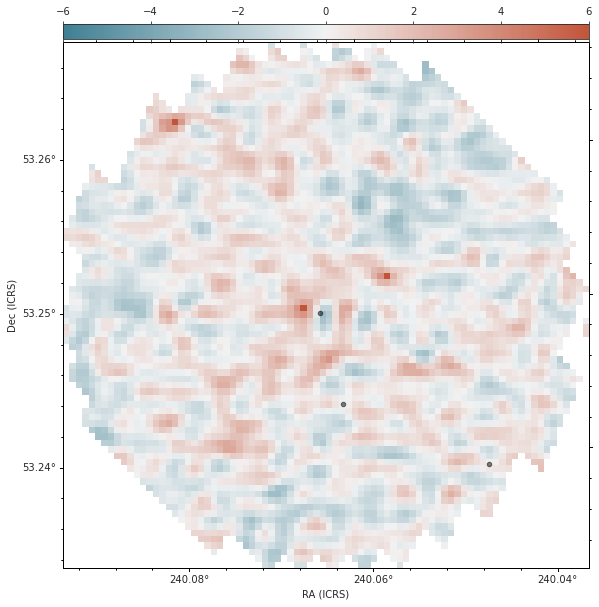

In [66]:
figs,fig=xidplus.plot_Bayes_pval_map([prior], posterior)

In [68]:
cat_tmp = xidplus.catalogue.create_LOFAR_cat(posterior,prior)
catalogue = Table.read(cat_tmp)
catalogue.rename_column('help_id','Component_Name')
catalogue_prf = join(catalogue,lofar_orig,keys='Component_Name',)

catalogue = join(catalogue_prf,catalogue_prfs,keys='Component_Name',table_names=['prf','prfs'])

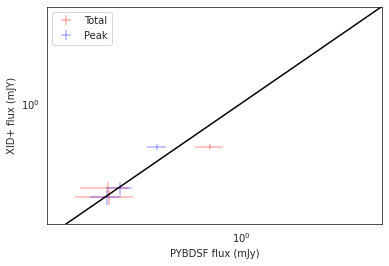

In [71]:
x = catalogue_prf['Total_flux']*1000
xerr = catalogue_prf['E_Total_flux']*1000
y = catalogue_prf['F_LOFAR_150']
yerr = catalogue_prf['FErr_LOFAR_150_u'] - catalogue_prf['FErr_LOFAR_150_l']

plt.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='',c='red',label='Total',alpha=0.3)

x = catalogue_prf['Peak_flux']*1000
xerr = catalogue_prf['E_Peak_flux']*1000
y = catalogue_prf['F_LOFAR_150']
yerr = catalogue_prf['FErr_LOFAR_150_u'] - catalogue_prf['FErr_LOFAR_150_l']

plt.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='',c='blue',label='Peak',alpha=0.3)

plt.plot([0,100],[0,100],c='black')
plt.yscale('log')
plt.xscale('log')


plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('PYBDSF flux (mJy)')
plt.ylabel('XID+ flux (mJY)')
plt.legend()
plt.show()

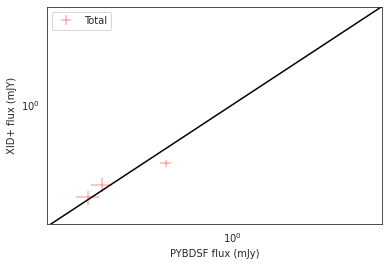

In [70]:
x = catalogue['F_LOFAR_150_prf']
xerr = catalogue['FErr_LOFAR_150_u_prf'] - catalogue['FErr_LOFAR_150_l_prf']
y = catalogue['F_LOFAR_150_prfs']
yerr = catalogue['FErr_LOFAR_150_u_prfs'] - catalogue['FErr_LOFAR_150_l_prfs']

plt.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='',c='red',label='Total',alpha=0.3)




plt.plot([0,100],[0,100],c='black')
plt.yscale('log')
plt.xscale('log')


plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('PYBDSF flux (mJy)')
plt.ylabel('XID+ flux (mJY)')
plt.legend()
plt.show()